# Machine Learning: Accident Severity Prediction

## Change Directories

In [1]:
import os
current_dir = os.getcwd()
current_dir

'/Users/mahahussain/Desktop/UK-Road-Accident-Analysis/UK-Road-Accident-Analysis/jupyter_notebooks'

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


In [3]:
current_dir = os.getcwd()
current_dir

'/Users/mahahussain/Desktop/UK-Road-Accident-Analysis/UK-Road-Accident-Analysis'

In [4]:
import pandas as pd 
import numpy as np
import seaborn as sns
sns.set_style('whitegrid')

# Model 1 : Multinomial Logistic Regression

The aim of this ML model is to predict the severity of an accident based on the input features.

**The severity of an accident is classified into 3 categories:**
1. Fatal
2. Serious
3. Slight

Therefore, a multinomial logistic regression model will be used to predict the severity of an accident.

**Inputs:**
1. Data: 'filtered_accident_data_set.csv'

**Outputs:**

### Workflow plan:
1. Data Prepocessing
1. Split dataset into train and test set.
2. Create pipeline for feature selection, scaling, and model fitting.
3. Evaluate model with the test set.

## 1. Data Preprocessing

### Exploring data

In [5]:
df = pd.read_csv('filtered_accident_data_set.csv')

og_df = df.copy() # save the original data set in case we need it later

df.head()

,Index,Accident_Severity,Accident Date,Latitude,Light_Conditions,District Area,Longitude,Number_of_Casualties,Number_of_Vehicles,Road_Surface_Conditions,Road_Type,Urban_or_Rural_Area,Vehicle_Type
0,200720D003001,Slight,02-01-2019,52.513668,Darkness - lights lit,Birmingham,-1.901975,1,2,Wet or damp,Dual carriageway,Urban,Car
1,200720D003101,Slight,02-01-2019,52.502396,Daylight,Birmingham,-1.867086,1,2,Wet or damp,Single carriageway,Urban,Car
2,200720D003802,Serious,03-01-2019,52.563201,Daylight,Birmingham,-1.822793,1,1,Dry,Single carriageway,Urban,Car
3,200720D005801,Slight,02-01-2019,52.493431,Daylight,Birmingham,-1.818507,1,2,Wet or damp,Dual carriageway,Urban,Car
4,200720D005901,Slight,05-01-2019,52.510805,Darkness - lights lit,Birmingham,-1.834202,1,3,Dry,Dual carriageway,Urban,Car


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32657 entries, 0 to 32656
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Index                    32657 non-null  object 
 1   Accident_Severity        32657 non-null  object 
 2   Accident Date            32657 non-null  object 
 3   Latitude                 32657 non-null  float64
 4   Light_Conditions         32657 non-null  object 
 5   District Area            32657 non-null  object 
 6   Longitude                32657 non-null  float64
 7   Number_of_Casualties     32657 non-null  int64  
 8   Number_of_Vehicles       32657 non-null  int64  
 9   Road_Surface_Conditions  32657 non-null  object 
 10  Road_Type                32657 non-null  object 
 11  Urban_or_Rural_Area      32657 non-null  object 
 12  Vehicle_Type             32657 non-null  object 
dtypes: float64(2), int64(2), object(9)
memory usage: 3.2+ MB


### Preprocessing checks

In [7]:
# print num of duplicate rows
print( f'there are ',df.duplicated().sum(), ' duplicate rows')


there are  0  duplicate rows


<Axes: >

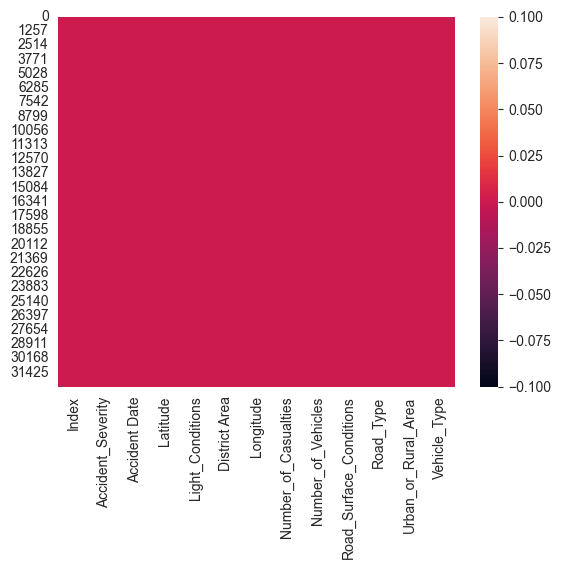

In [8]:
# Heatmap to check missing values
sns.heatmap(df.isnull())

Accident index has no relevance on the prediction of accident severity, therefore this column will be dropped.

In [9]:
df.drop(['Index'], axis=1, inplace=True)

# verify if the column was dropped
df.head()

,Accident_Severity,Accident Date,Latitude,Light_Conditions,District Area,Longitude,Number_of_Casualties,Number_of_Vehicles,Road_Surface_Conditions,Road_Type,Urban_or_Rural_Area,Vehicle_Type
0,Slight,02-01-2019,52.513668,Darkness - lights lit,Birmingham,-1.901975,1,2,Wet or damp,Dual carriageway,Urban,Car
1,Slight,02-01-2019,52.502396,Daylight,Birmingham,-1.867086,1,2,Wet or damp,Single carriageway,Urban,Car
2,Serious,03-01-2019,52.563201,Daylight,Birmingham,-1.822793,1,1,Dry,Single carriageway,Urban,Car
3,Slight,02-01-2019,52.493431,Daylight,Birmingham,-1.818507,1,2,Wet or damp,Dual carriageway,Urban,Car
4,Slight,05-01-2019,52.510805,Darkness - lights lit,Birmingham,-1.834202,1,3,Dry,Dual carriageway,Urban,Car


### Defining target variable

Our chosen target variable is the accident severity. Our ML task will be classification.

In [10]:
df['Accident_Severity'].value_counts()

Accident_Severity
Slight     28566
Serious     3818
Fatal        273
Name: count, dtype: int64

## 2. Pipeline Setup

In [11]:
# import pipeline libraries
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# standard scaler --> scales numerical columns 
# one hot encoder --> encodes categorical columns
from sklearn.preprocessing import StandardScaler, OneHotEncoder 

# PCA --> Principal Component Analysis for dimensionality reduction
from sklearn.decomposition import PCA

# import model libraries
from sklearn.linear_model import LogisticRegression

# import train test split
from sklearn.model_selection import train_test_split

Pipeline steps:
1. Use standard scaler
2. One-Hot Encode categorical values
3. Use PCA after preprocessing
4. Use multiclass logistic regression model

In [12]:
# convert Accident Date to datetime
df['Accident Date'] = pd.to_datetime(df['Accident Date'], dayfirst=True)

# create new columns for year, month, day, weekday
df['Year'] = df['Accident Date'].dt.year
df['Month'] = df['Accident Date'].dt.month
df['Day'] = df['Accident Date'].dt.day
df['Weekday'] = df['Accident Date'].dt.weekday # 0 = Monday, 6 = Sunday

# drop Accident Date
df.drop('Accident Date', axis=1, inplace=True)

# shuffle the data set
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# split features (X) and target variable (y)
X_train, X_test, y_train, y_test = train_test_split(df.drop('Accident_Severity', axis=1), df['Accident_Severity'], test_size=0.2, random_state=42)

#test set = 20% of the data set
#train set = 80% of the data set

# print the shape of the sets
print('Training data set: ', X_train.shape, 
        '- y_train: ', y_train.shape, '\n'
        'Testing data set: ', X_test.shape,
        '- y_test: ', y_test.shape
        )

Training data set:  (26125, 14) - y_train:  (26125,) 
Testing data set:  (6532, 14) - y_test:  (6532,)


In [13]:
# Automatically define numerical and categorical columns from X_train
num = X_train.select_dtypes(include=np.number).columns.tolist()
cat = X_train.select_dtypes(include='object').columns.tolist()

# create transformer for column preprocessing
# standard scaler for numerical columns
# one hot encoder for categorical columns

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num),
        ('cat', OneHotEncoder(), cat)
    ]
)

### Model selection

We will use a multinomial logistic regression model.
- Our target variable (Accident Severity) has more than two categories (e.g., Slight, Serious, Fatal), so we're dealing with a multiclass classification problem.


**Preprocessing:**

- Numerical data (like numbers for location, casualties, etc.) is adjusted so they’re on the same scale (so no feature is too big or too small compared to others).
- Categorical data (like light conditions, road type) is converted into yes/no (1/0) columns, making it easier for the model to understand.

**Logistic Regression:**

- The model that will predict accident severity. It handles multiple types of severity (multi-class) and is set to run longer (max_iter=500) to make sure it gives a good result.

In [17]:
# create a pipeline with the preprocessor and the model

model = Pipeline([
    ('preprocessor', preprocessor),
    ('model', LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=500, class_weight='balanced'))
])

# class_weight='balanced' to handle imbalanced classes as Slight is the majority class

# print pipeline steps
model.steps

[('preprocessor',
  ColumnTransformer(transformers=[('num', StandardScaler(),
                                   ['Latitude', 'Longitude',
                                    'Number_of_Casualties', 'Number_of_Vehicles',
                                    'Year', 'Month', 'Day', 'Weekday']),
                                  ('cat', OneHotEncoder(),
                                   ['Light_Conditions', 'District Area',
                                    'Road_Surface_Conditions', 'Road_Type',
                                    'Urban_or_Rural_Area', 'Vehicle_Type'])])),
 ('model',
  LogisticRegression(class_weight='balanced', max_iter=500,
                     multi_class='multinomial'))]

### Train the model + Predict on the test set

In [15]:
# train the model
model.fit(X_train, y_train)

# predict the target variable
y_pred = model.predict(X_test)

## 4. Model Evaluation

              precision    recall  f1-score   support

       Fatal       0.02      0.59      0.04        59
     Serious       0.18      0.39      0.25       780
      Slight       0.92      0.52      0.66      5693

    accuracy                           0.50      6532
   macro avg       0.37      0.50      0.32      6532
weighted avg       0.83      0.50      0.61      6532

Predicted  Fatal  Serious  Slight
Actual                           
Fatal         35       12      12
Serious      241      307     232
Slight      1356     1400    2937


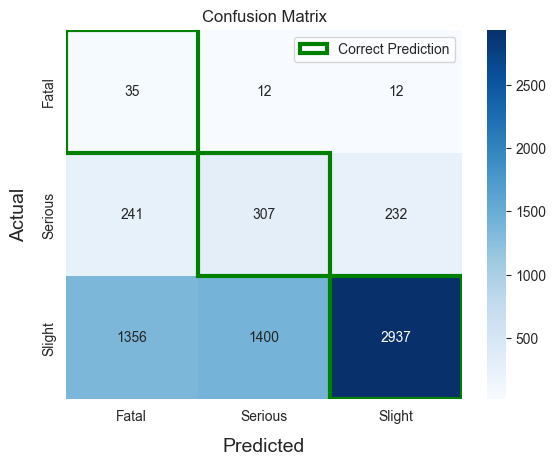

In [29]:
from sklearn.metrics import classification_report, confusion_matrix

# print classification report
print(classification_report(y_test, y_pred))

# print confusion matrix in a more readable format
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm, columns=np.unique(y_test), index = np.unique(y_test))
cm_df.index.name = 'Actual'
cm_df.columns.name = 'Predicted'
print(cm_df)

import matplotlib.pyplot as plt
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

# replace numbers for class names with the actual class names
plt.xticks(ticks=np.arange(3)+0.5, labels=np.unique(y_test))
plt.yticks(ticks=np.arange(3)+0.5, labels=np.unique(y_test))

# green border around the correct prediction squares
for i in range(3):
    plt.gca().add_patch(plt.Rectangle((i, i), 1, 1, fill=False, edgecolor='green', linewidth=3))
plt.legend(['Correct Prediction'], loc='upper right')



plt.xlabel('Predicted', fontsize=14, labelpad=10)
plt.ylabel('Actual', fontsize=14, labelpad=10)
plt.title('Confusion Matrix')
plt.show()




- **Fatal**: Recall is high (0.59), but precision is very low (0.02). This means the model is good at identifying some "Fatal" accidents, but it's predicting "Fatal" too often when it shouldn't.


- **Serious**: Both precision (0.18) and recall (0.39) are low, indicating the model struggles to correctly classify "Serious" accidents.


- **Slight**: Precision (0.92) is high, meaning the model is good at predicting "Slight" accidents. But the recall (0.52) is lower, indicating it misses some of the "Slight" cases, possibly due to misclassifying them as "Serious" or "Fatal".


- **Accuracy**: The accuracy is 50%, which suggests the model is heavily biased towards predicting "Slight" accidents, given how many there are in the dataset.

### Confusion Matrix:

- **"Fatal" accidents**: Many of these are misclassified as "Serious" or "Slight".
- **"Serious" accidents**: These are often misclassified as "Slight".
- **"Slight" accidents**: A lot are correctly identified, but some are misclassified as "Serious".

## 5. Challenges and Areas for Improvement

- Imbalanced Dataset: The model's bias toward predicting "Slight" accidents is a direct result of the imbalance in the dataset, where "Slight" accidents vastly outnumber "Fatal" and "Serious" accidents.

- Address Data Imbalance: We plan to implement SMOTE (Synthetic Minority Over-sampling Technique) to generate synthetic samples for the minority classes ("Serious" and "Fatal"), which should help improve model performance on these categories.

## x. Next Steps

- Model Limitations: Although Multinomial Logistic Regression is suitable for multi-class problems, it may not be the best model for dealing with the imbalanced data. The low performance for "Serious" and "Fatal" accidents suggests that a more complex model may be needed.

- Experiment with More Complex Models: After addressing the class imbalance, we will experiment with more sophisticated models, such as Random Forest, which can better capture non-linear relationships in the data and may perform better in multi-class settings.

# Model 2 : Random Forest